<a href="https://colab.research.google.com/github/Sangeetha2998/Stock-price-prediction/blob/main/Market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.0147 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0013 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.8313e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.8163e-04 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.5735e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.3271e-04 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.2367e-04 - val_loss: 9.7917e-04 - learnin

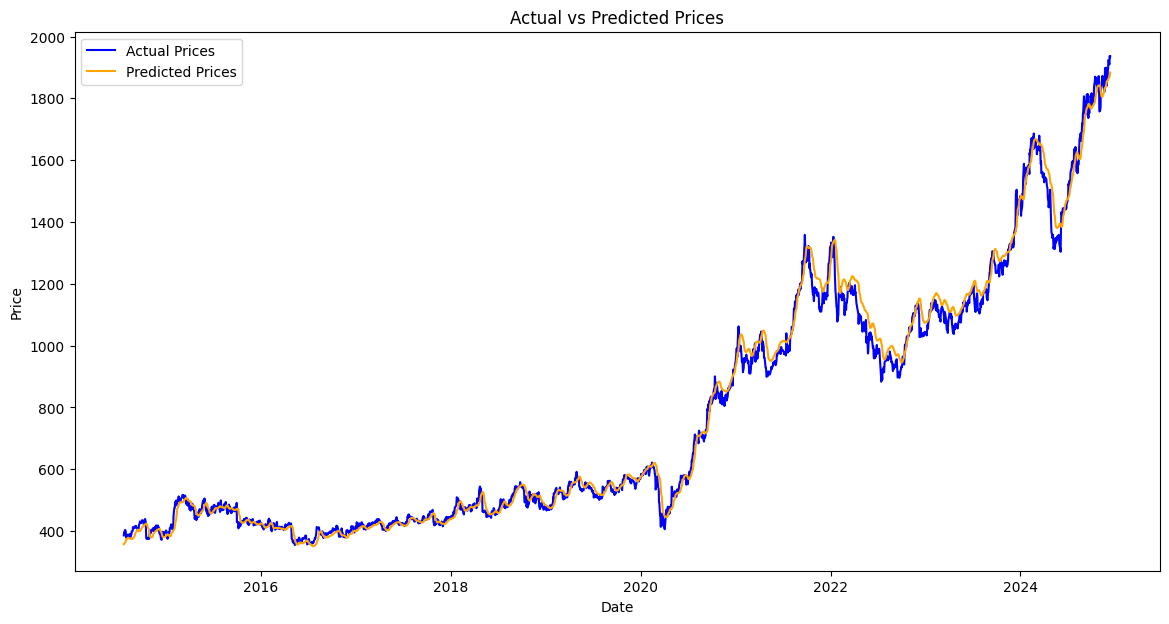

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Step 1: Getting Data from Yfinance
ticker = 'HCLTECH.NS'
data = yf.download(ticker, start='2014-01-01', end='2024-12-13', interval='1d')  # Daily data for 8 years aprox to increase accracy

# Step 2: Data Preprocessing
data['Close'] = data['Close'].astype(float)

# Feature Engineering
data['SMA'] = data['Close'].rolling(window=20).mean()  # Simple Moving Average which helps in knowing between which interval this price stands
data['EMA'] = data['Close'].ewm(span=20, adjust=False).mean()  # Exponential Moving Average
data['Volume'] = data['Volume'].astype(float)  # To ensure Volume is float

# Drop rows with NaN values if there are any
data.dropna(inplace=True)


data = data[['Close', 'SMA', 'EMA', 'Volume']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for LSTM and GRU (Using two models to increase accuracy)
def create_sequences(data, time_steps=1):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 0])
    return np.array(x), np.array(y)

time_steps = 60
x, y = create_sequences(scaled_data, time_steps)
x = np.reshape(x, (x.shape[0], x.shape[1], x.shape[2]))

from keras.layers import Input

# Step 3: Model Building
model = Sequential()

# Adding Input layer and LSTM layers
model.add(Input(shape=(x.shape[1], x.shape[2])))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

# Adding GRU layers
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # Predicting the next closing price
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 4: Model Training with Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Fit the model
model.fit(x, y, epochs=100, batch_size=32, verbose=1,
          validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Step 5: Prediction
last_prices = scaled_data[-time_steps:]
last_prices = last_prices.reshape(1, -1, last_prices.shape[1])

predicted_prices = []
for _ in range(10):  # Predicting for the next 10 days
    predicted_price_scaled = model.predict(last_prices)

    # Create a temporary array to hold the predicted price and the other features
    temp_array = np.zeros((1, 1, last_prices.shape[2]))
    temp_array[0, 0, 0] = predicted_price_scaled[0, 0]  # Close price
    temp_array[0, 0, 1:] = last_prices[0, -1, 1:]  # Other features

    # Update last_prices for the next prediction
    last_prices = np.append(last_prices[:, 1:, :], temp_array, axis=1)

    # Inverse transform to get the actual price
    predicted_price = scaler.inverse_transform(temp_array[0])  # Get the actual price
    predicted_prices.append(predicted_price[0][0])  # Store the 'Close' price

# Print predicted prices for the next 10 days
print("Predicted prices for the next 10 days:", predicted_prices)

# Step 6: Model Evaluation
# Prepare the test set
x_eval, y_eval = create_sequences(scaled_data[-(len(data) - time_steps):], time_steps)
x_eval = np.reshape(x_eval, (x_eval.shape[0], x_eval.shape[1], x_eval.shape[2]))

# Predictions on the evaluation set
y_pred = model.predict(x_eval)
# Step 6: Model Evaluation (continued)
y_pred_inverse = scaler.inverse_transform(np.concatenate((y_pred, x_eval[:, -1, 1:].reshape(-1, x_eval.shape[2] - 1)), axis=1))

# Calculate evaluation metrics
mse = mean_squared_error(y_eval, y_pred_inverse[:, 0])
mae = mean_absolute_error(y_eval, y_pred_inverse[:, 0])

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

# Optional: Plotting the results for visual inspection
import matplotlib.pyplot as plt

# Plotting the actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_eval):], data['Close'].values[-len(y_eval):], label='Actual Prices', color='blue')
plt.plot(data.index[-len(y_eval):], y_pred_inverse[:, 0], label='Predicted Prices', color='orange')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



In [3]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install TA-Lib

--2024-12-16 05:20:18--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:c95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-12-16 05:20:18--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:c95, ...
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://pilotfiber.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-12-16 05:20:18--  http://pilotfiber.dl.